In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.neighbors import LocalOutlierFactor
from scipy.spatial.distance import cdist

In [2]:
gps_data = pd.read_csv('gps_gyro_data/Walking_GPS_2025_06_04_19_35_39.csv')

In [3]:
gps_data.head()

,Time (s),Latitude (°),Longitude (°),Altitude (m),Altitude WGS84 (m),Speed (m/s),Direction (°),Distance (km),Horizontal Accuracy (m),Vertical Accuracy (m),Satellites
0,0.143797,52.167857,4.503114,5.210720,48.368458,1.06,279.492188,0.001789,7.926995,4.0,-1
1,1.143812,52.167863,4.503090,6.649868,49.807612,1.06,271.757812,0.006861,6.419400,4.0,-1
2,2.143828,52.167905,4.503118,6.126186,49.283859,0.82,272.109375,0.009395,5.508326,4.0,-1
3,3.143843,52.167920,4.503145,6.135403,49.293040,0.58,272.460938,0.009739,5.404943,4.0,-1
4,4.141159,52.167917,4.503144,6.480556,49.638198,0.80,272.460938,0.011070,4.846990,4.0,-1


In [4]:
# Calculate the percentage of NaNs for each column
nan_percentage = gps_data.isna().mean() * 100


# Print nicely
print(nan_percentage.round(2).sort_values(ascending=False))

Direction (°)              0.77
Distance (km)              0.11
Time (s)                   0.00
Latitude (°)               0.00
Longitude (°)              0.00
Altitude (m)               0.00
Altitude WGS84 (m)         0.00
Speed (m/s)                0.00
Horizontal Accuracy (m)    0.00
Vertical Accuracy (m)      0.00
Satellites                 0.00
dtype: float64


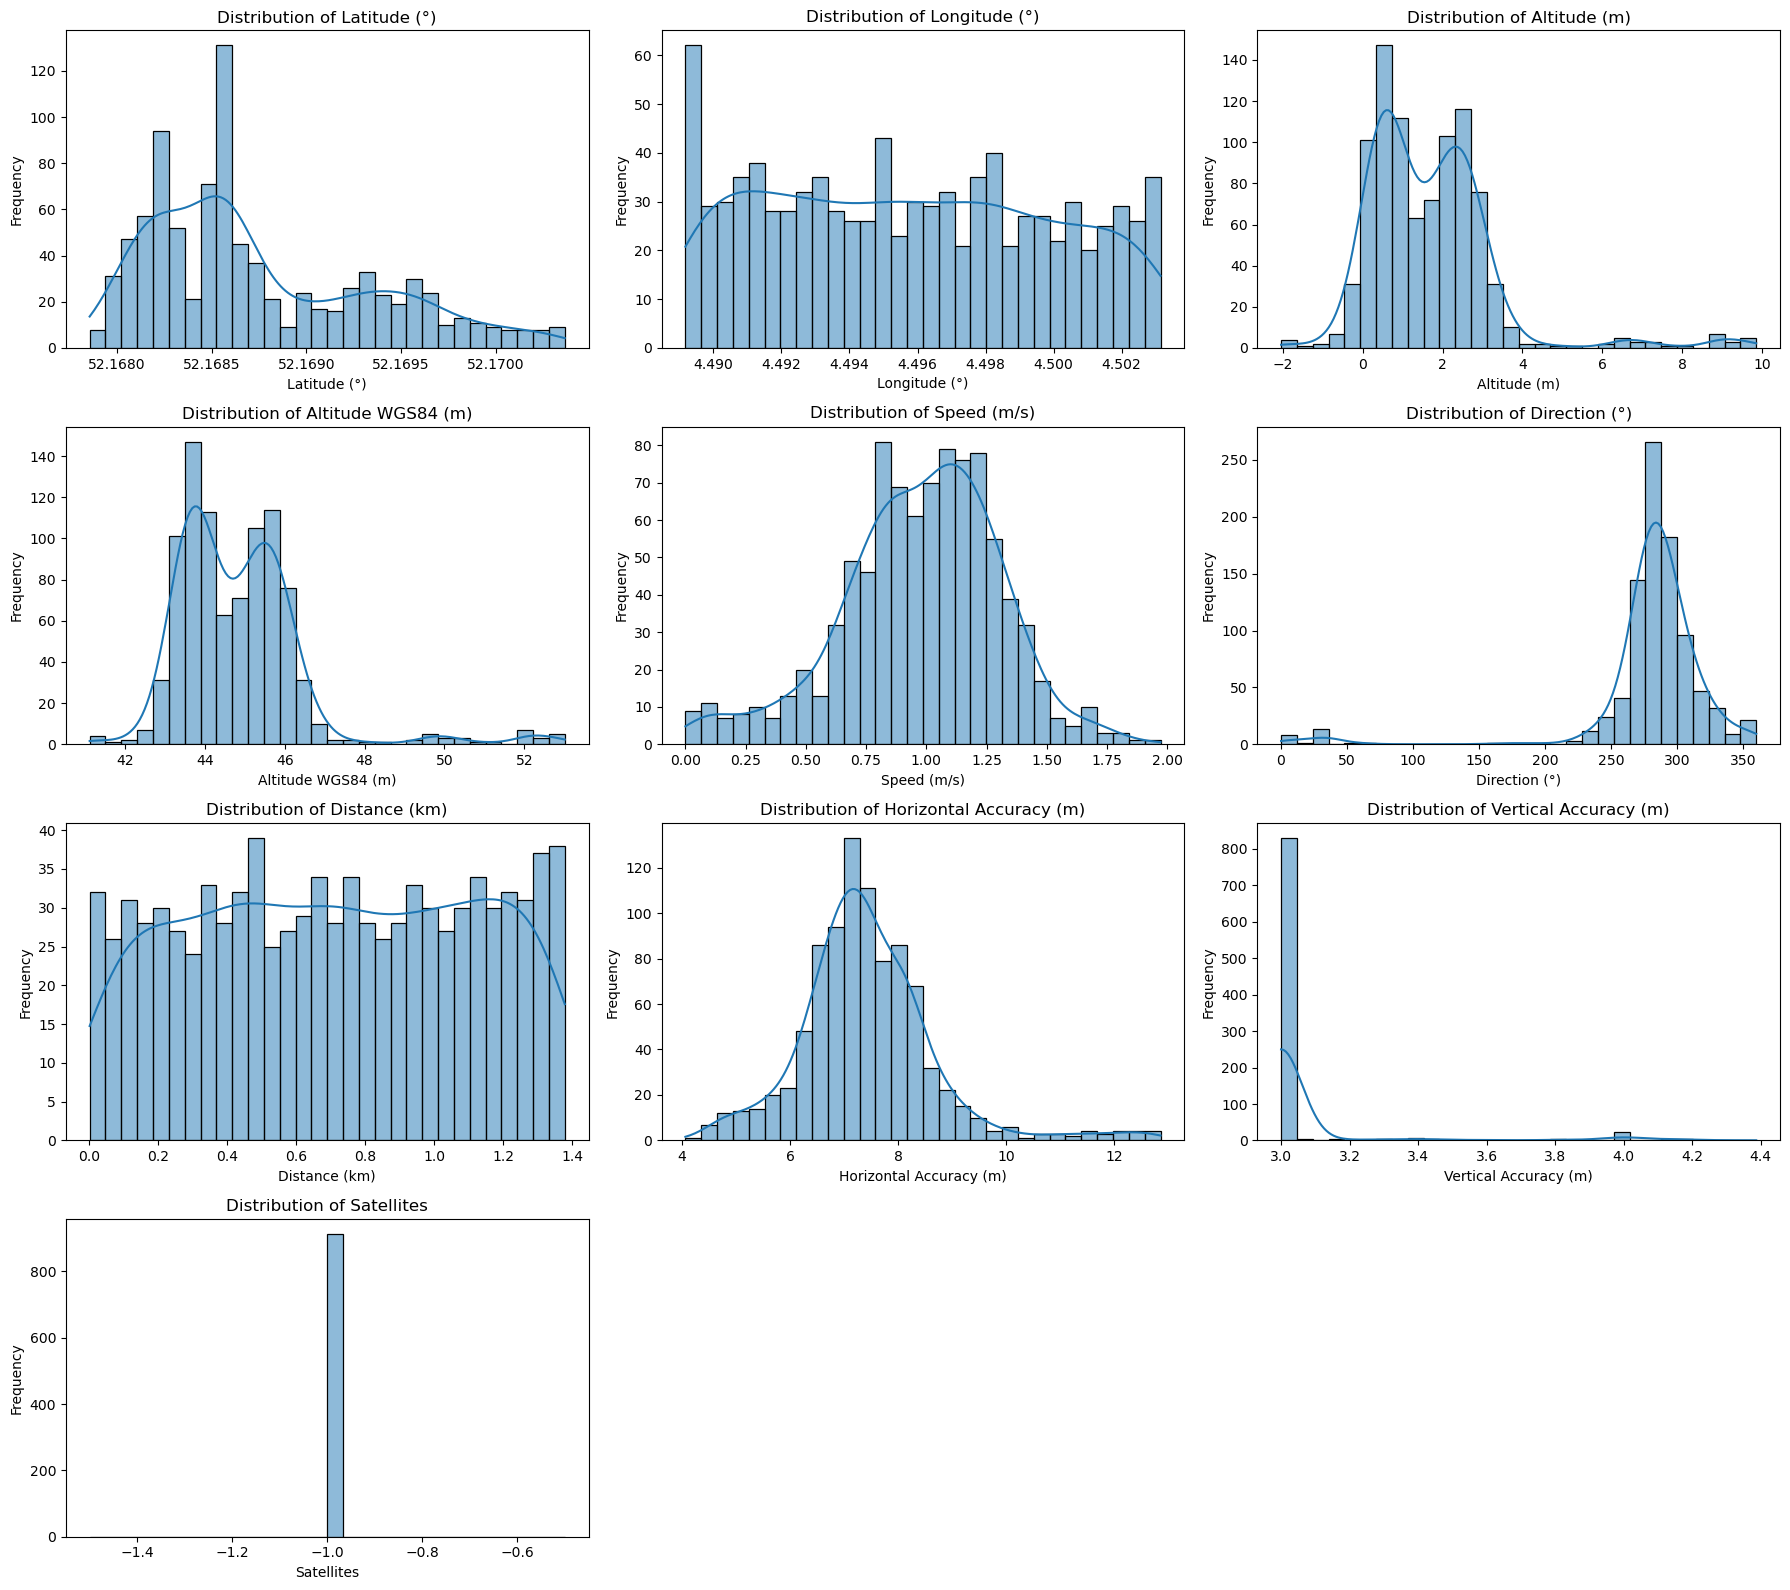

In [5]:
# Drop the 'Time (s)' column for this purpose
gps_data_copy = gps_data.copy()
features_to_plot = gps_data_copy.columns.drop("Time (s)")

# Determine grid size
num_features = len(features_to_plot)
cols = 3
rows = (num_features + cols - 1) // cols  # round up division

# Create figure and axes
plt.figure(figsize=(6 * cols, 4 * rows))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(gps_data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [6]:
# Use only the 'Speed (m/s)' feature
X_speed = gps_data[["Speed (m/s)"]]

# Mask for non-missing values
valid_mask_speed = X_speed.notnull().squeeze()

# Prepare result containers
lof_labels_speed = pd.Series([np.nan] * len(X_speed), index=X_speed.index)
lof_scores_speed = pd.Series([np.nan] * len(X_speed), index=X_speed.index)

# Apply LOF on valid values
lof_speed = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
X_valid_speed = X_speed[valid_mask_speed]
lof_result_speed = lof_speed.fit_predict(X_valid_speed)
lof_score_result_speed = lof_speed.negative_outlier_factor_

# Assign back to full DataFrame
lof_labels_speed[valid_mask_speed] = lof_result_speed
lof_scores_speed[valid_mask_speed] = lof_score_result_speed

# Add to original DataFrame
gps_data["LOF_Score_Speed"] = lof_scores_speed
gps_data["Outlier_Speed"] = lof_labels_speed

In [7]:
# Choose the features to use
features = ["Speed (m/s)"]
X = gps_data[features].copy()

# Identify rows with no missing values in the selected features
valid_mask = X.notnull().all(axis=1)

# Prepare storage for results
lof_labels = pd.Series([np.nan] * len(X), index=X.index)
lof_scores = pd.Series([np.nan] * len(X), index=X.index)

# Apply LOF only on valid rows
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.04)
X_valid = X[valid_mask]
lof_result = lof_model.fit_predict(X_valid)
lof_score_result = lof_model.negative_outlier_factor_

# Insert results back into full DataFrame
lof_labels[valid_mask] = lof_result
lof_scores[valid_mask] = lof_score_result

# Append results to original DataFrame
gps_data["LOF_Score"] = lof_scores
gps_data["Outlier"] = lof_labels

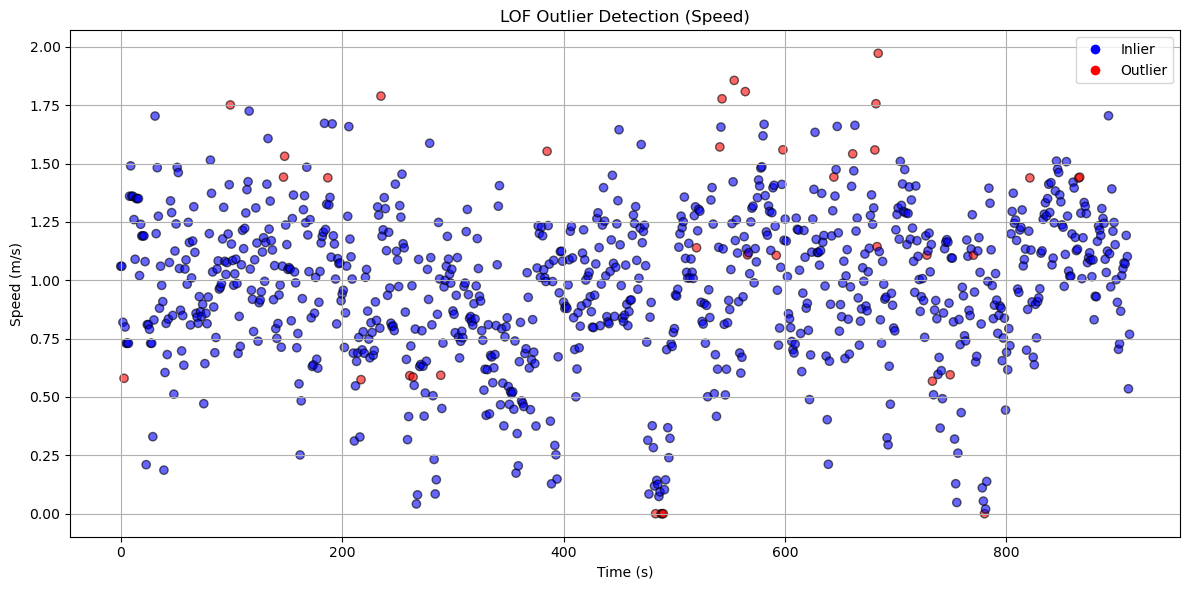

In [8]:
# Filter rows where LOF was evaluated
gps_data_plot = gps_data[gps_data["Outlier"].notna()]

# Map colors: red = outlier, blue = inlier
colors = gps_data_plot["Outlier"].map({1: "blue", -1: "red"})

# Plot speed over time with color-coded outliers
plt.figure(figsize=(12, 6))
plt.scatter(gps_data_plot["Time (s)"], gps_data_plot["Speed (m/s)"], c=colors, alpha=0.6, edgecolor='k')
plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")
plt.title("LOF Outlier Detection (Speed)")
plt.grid(True)
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Inlier', markerfacecolor='blue', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Outlier', markerfacecolor='red', markersize=8)
])
plt.tight_layout()
plt.savefig("LOF_Speed.png", dpi=300, bbox_inches='tight')
plt.show()


In [9]:
# Select relevant features (e.g., speed and direction for GPS data)
X = gps_data[["Speed (m/s)", "Direction (°)"]].dropna()

# Fit the LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # adjust contamination as needed
y_pred = lof.fit_predict(X)

# -1 for outliers, 1 for inliers
X["LOF_Score"] = lof.negative_outlier_factor_
X["Outlier"] = y_pred

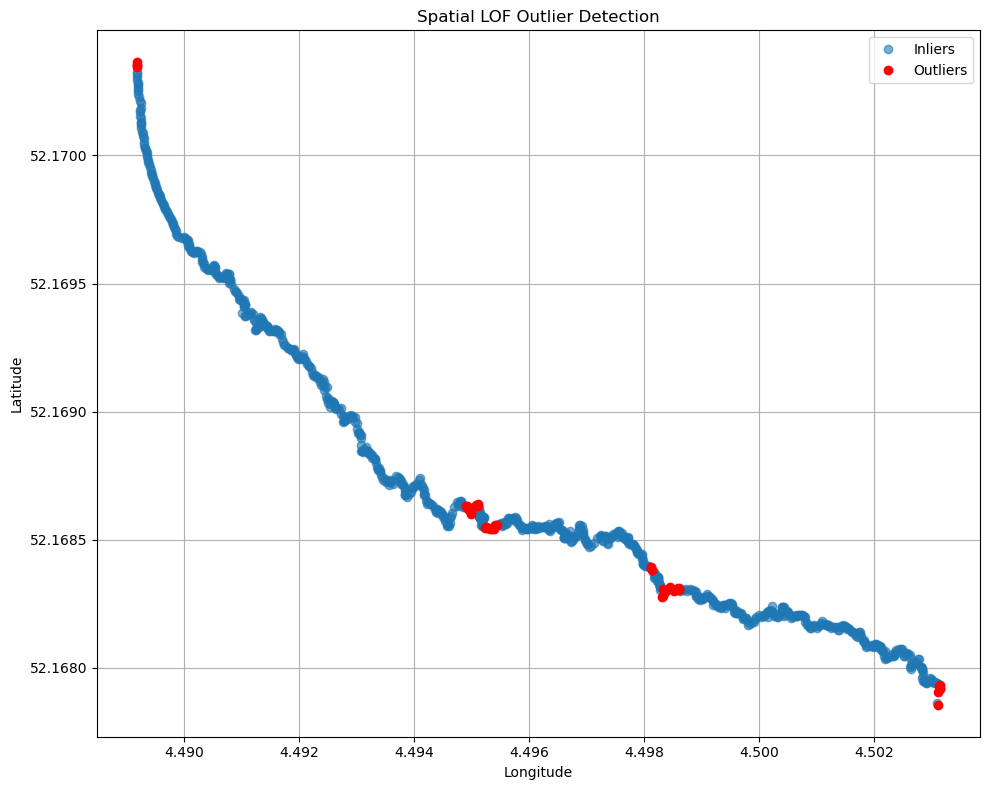

In [10]:
# Extract Latitude and Longitude
spatial_data = gps_data[['Latitude (°)', 'Longitude (°)']].dropna()

# Run LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
outlier_flags = lof.fit_predict(spatial_data)

# Add outlier flag to dataframe
spatial_data = spatial_data.copy()
spatial_data['Outlier'] = outlier_flags

# Plotting
plt.figure(figsize=(10, 8))
inliers = spatial_data[spatial_data['Outlier'] == 1]
outliers = spatial_data[spatial_data['Outlier'] == -1]

plt.plot(inliers['Longitude (°)'], inliers['Latitude (°)'], 'o', label='Inliers', alpha=0.6)
plt.plot(outliers['Longitude (°)'], outliers['Latitude (°)'], 'ro', label='Outliers')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial LOF Outlier Detection')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("LOF_Spatial_Outliers.png", dpi=300)
plt.show()

In [11]:
# Make a copy of the original data
cleaned_data = gps_data.copy()

# Replace outlier values in Speed (based on LOF_Score_Speed)
cleaned_data.loc[cleaned_data["Outlier_Speed"] == -1, "Speed (m/s)"] = np.nan

# Replace outlier values in Direction
cleaned_data.loc[cleaned_data["Outlier"] == -1, "Direction (°)"] = np.nan

# Replace spatial outliers (Longitude and Latitude) if needed
spatial_outlier_mask = spatial_data['Outlier'] == -1
cleaned_data.loc[spatial_outlier_mask, ['Latitude (°)', 'Longitude (°)']] = np.nan

# Calculate the percentage of NaNs for each column
nan_percentage = cleaned_data.isna().mean() * 100


# Print nicely
print(nan_percentage.round(2).sort_values(ascending=False))

Latitude (°)               5.04
Longitude (°)              5.04
Speed (m/s)                5.04
Direction (°)              4.82
Distance (km)              0.11
Time (s)                   0.00
Altitude (m)               0.00
Altitude WGS84 (m)         0.00
Horizontal Accuracy (m)    0.00
Vertical Accuracy (m)      0.00
Satellites                 0.00
LOF_Score_Speed            0.00
Outlier_Speed              0.00
LOF_Score                  0.00
Outlier                    0.00
dtype: float64


In [12]:
cleaned_data.tail(30)

,Time (s),Latitude (°),Longitude (°),Altitude (m),Altitude WGS84 (m),Speed (m/s),Direction (°),Distance (km),Horizontal Accuracy (m),Vertical Accuracy (m),Satellites,LOF_Score_Speed,Outlier_Speed,LOF_Score,Outlier
882,882.140407,52.170068,4.489289,0.451722,43.615842,1.166655,332.925842,1.344448,9.173699,3.464974,-1,-0.960744,1.0,-0.960744,1.0
883,883.140410,52.170078,4.489284,0.345370,43.509481,1.232942,332.925842,1.345748,9.089471,3.396501,-1,-0.997625,1.0,-0.997625,1.0
884,884.140413,52.170088,4.489275,0.003991,43.168095,1.214953,335.342468,1.346979,8.995463,3.302790,-1,-0.982719,1.0,-0.982719,1.0
885,885.140417,52.170092,4.489258,0.150286,43.314397,1.191788,335.342468,1.348625,8.958475,3.288122,-1,-0.984311,1.0,-0.984311,1.0
886,886.140057,52.170106,4.489252,0.209407,43.373504,1.306986,335.342468,1.350027,8.662359,3.140837,-1,-0.990028,1.0,-0.990028,1.0
887,887.140060,52.170118,4.489245,1.085277,44.249362,1.264558,335.342468,1.351123,8.622344,3.058022,-1,-1.042732,1.0,-1.042732,1.0
888,888.140064,52.170128,4.489245,0.628736,43.792808,1.244157,337.237610,1.351620,8.717215,3.000000,-1,-0.978099,1.0,-0.978099,1.0
889,889.140066,52.170133,4.489245,-0.814772,42.349294,1.089939,337.237610,1.352991,8.621876,3.000000,-1,-0.965239,1.0,-0.965239,1.0
890,890.140063,52.170145,4.489239,-0.295051,42.869003,1.033295,355.514110,1.354310,8.459820,3.000000,-1,-1.015592,1.0,-1.015592,1.0
891,891.140066,52.170155,4.489230,-0.271777,42.892270,1.124952,340.368500,1.356028,8.377549,3.000000,-1,-0.957146,1.0,-0.957146,1.0


In [14]:
# Columns to fix at the edges
edge_columns = ['Speed (m/s)', 'Latitude (°)', 'Longitude (°)', 'Distance (km)']

for col in edge_columns:
    if col in cleaned_data.columns:
        # Backfill NaNs in the first 10 rows by position
        cleaned_data.iloc[:10, cleaned_data.columns.get_loc(col)] = \
            cleaned_data.iloc[:10, cleaned_data.columns.get_loc(col)].fillna(method='bfill')

        # Forward-fill NaNs in the last 10 rows by position
        cleaned_data.iloc[-10:, cleaned_data.columns.get_loc(col)] = \
            cleaned_data.iloc[-10:, cleaned_data.columns.get_loc(col)].fillna(method='ffill')

cleaned_data.head()

C:\Users\iChin\AppData\Local\Temp\ipykernel_29028\3080948332.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_data.iloc[:10, cleaned_data.columns.get_loc(col)].fillna(method='bfill')
C:\Users\iChin\AppData\Local\Temp\ipykernel_29028\3080948332.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_data.iloc[-10:, cleaned_data.columns.get_loc(col)].fillna(method='ffill')
C:\Users\iChin\AppData\Local\Temp\ipykernel_29028\3080948332.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_data.iloc[:10, cleaned_data.columns.get_loc(col)].fillna(method='bfill')
C:\Users\iChin\AppData\Local\Temp\ipykernel_29028\3080948332.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futu

In [15]:
# Calculate the percentage of NaNs for each column
nan_percentage = cleaned_data.isna().mean() * 100


# Print nicely
print(nan_percentage.round(2).sort_values(ascending=False))

Speed (m/s)                4.93
Direction (°)              4.82
Latitude (°)               3.95
Longitude (°)              3.95
Time (s)                   0.00
Altitude (m)               0.00
Altitude WGS84 (m)         0.00
Distance (km)              0.00
Horizontal Accuracy (m)    0.00
Vertical Accuracy (m)      0.00
Satellites                 0.00
LOF_Score_Speed            0.00
Outlier_Speed              0.00
LOF_Score                  0.00
Outlier                    0.00
dtype: float64


In [42]:
# Columns to interpolate
columns_to_interpolate = ['Speed (m/s)', 'Latitude (°)', 'Longitude (°)', 'Distance (km)']

for col in columns_to_interpolate:
    if col in cleaned_data.columns:
        cleaned_data[col] = (
            cleaned_data[col]
            .interpolate(method='linear')
            .fillna(method='bfill')
            .fillna(method='ffill')
        )

# Check NaN percentages after interpolation
nan_percentage = cleaned_data[columns_to_interpolate].isna().mean() * 100
print(nan_percentage.round(2).sort_values(ascending=False))


Speed (m/s)      0.0
Latitude (°)     0.0
Longitude (°)    0.0
Distance (km)    0.0
dtype: float64


C:\Users\iChin\AppData\Local\Temp\ipykernel_29028\2577251828.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
C:\Users\iChin\AppData\Local\Temp\ipykernel_29028\2577251828.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')
